# Data Pre-processing for Astrophysical Origin Classification Model

In this notebook, we will prepare data for a machine learning model to handle the following task: To predict whether a detection event will have a very high probability of astrophysical origin based just on the value of its matched filter singal-to-noise ratio (SNR).

To accomplish this, we will first need to define a treshhold for "very high astrophysical probability", and then create a train-test split of our data.

## Loading the data

Since we are building a machine learning model, the more data the better, so we actually want to import the original dataset which includes events with 'p_astro' < 0.8 which we had dropped for our EDA notebook. Not doing so would create a very imbalanced dataset for modeling. 

Since we are only iterested in two columns: 'network_mathed_filter_snr' as a feature and 'p_astro' as our target variable, we can ignore all the other cleaning steps we took for the other columns in previous notebooks. The only thing we still want to do is to make sure the dataset contains only confidently detected events (and drop auxillary and marginal detections we had originally noticed):

In [1]:
import pandas as pd

gw_data = pd.read_csv('GWTC.csv')
gw_confident = gw_data[gw_data['catalog.shortName'].str.contains('confident')].reset_index(drop = True)

Next we can simplify the dataset by keepling only the columns that we are interested in:

In [2]:
df = gw_confident[['commonName','network_matched_filter_snr', 'p_astro']]
df

,commonName,network_matched_filter_snr,p_astro
0,GW150914,26.0,1.00000
1,GW151012,10.0,1.00000
2,GW151226,13.1,1.00000
3,GW170104,13.8,1.00000
4,GW170608,15.4,1.00000
...,...,...,...
85,GW200306_093714,7.8,0.81156
86,GW200308_173609,7.1,0.85660
87,GW200311_115853,17.8,0.99000
88,GW200316_215756,10.3,0.99000


## Binarizing target variable

Now we need to define a treshold value for "very high astrophysical probability". To do so we will first look at the distribution of values and some summary statistics:

In [3]:
df.describe()

,network_matched_filter_snr,p_astro
count,90.000000,90.000000
mean,12.357778,0.923763
std,4.891129,0.123516
min,6.000000,0.543340
25%,9.025000,0.879422
50%,10.850000,0.990000
75%,13.350000,1.000000
max,33.000000,1.000000


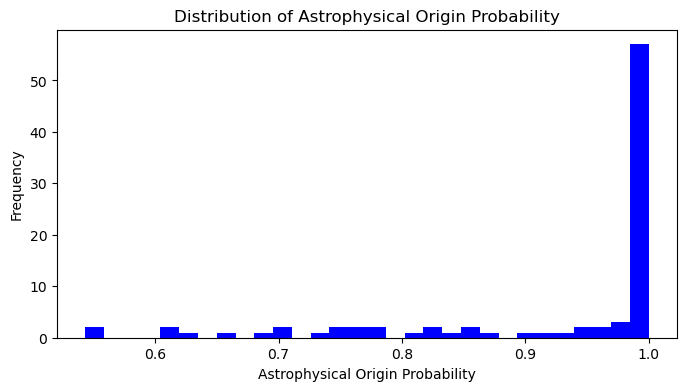

In [4]:
import matplotlib.pyplot as plt

# Checking the distribution of the 'p_astro' column
plt.figure(figsize=(8, 4))
plt.hist(df['p_astro'], bins=30, color = 'blue')
plt.title('Distribution of Astrophysical Origin Probability')
plt.xlabel('Astrophysical Origin Probability')
plt.ylabel('Frequency')

plt.show()

Given that the 50% percentile value for p_astro is 0.99 and by what we can also see from the plot, it looks like about half the values are >= 0.99 and the other half < 0.99, so we will choose that as the treshold.

In [9]:
threshold = 0.99

# Using .loc for safe assignment
df.loc[:, 'p_astro_binary'] = (df['p_astro'] >= threshold).astype(int)
df

,commonName,network_matched_filter_snr,p_astro,p_astro_binary
0,GW150914,26.0,1.00000,1
1,GW151012,10.0,1.00000,1
2,GW151226,13.1,1.00000,1
3,GW170104,13.8,1.00000,1
4,GW170608,15.4,1.00000,1
...,...,...,...,...
85,GW200306_093714,7.8,0.81156,0
86,GW200308_173609,7.1,0.85660,0
87,GW200311_115853,17.8,0.99000,1
88,GW200316_215756,10.3,0.99000,1


Let's check the balance of our dataset by seeing the distribution of classes for p_astro_binary:

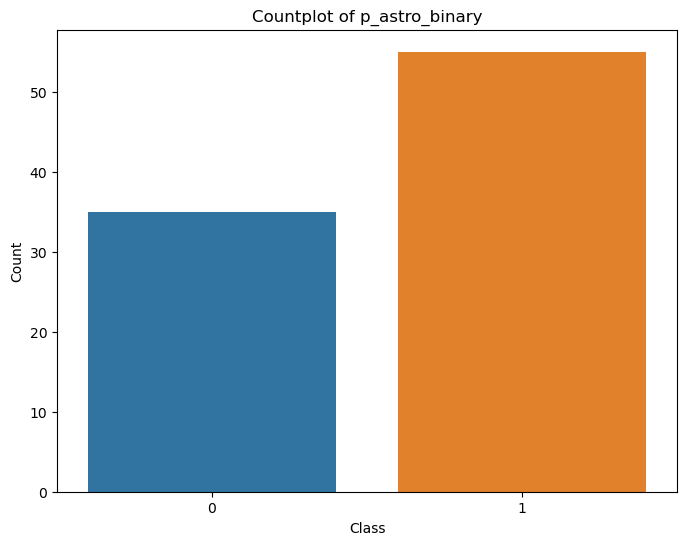

p_astro_binary
1    61.111111
0    38.888889
Name: proportion, dtype: float64


In [6]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='p_astro_binary', data=df)
plt.title('Countplot of p_astro_binary')
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

class_distribution_pct = df['p_astro_binary'].value_counts(normalize=True) * 100
print(class_distribution_pct)

So not a perfectly balanced dataset (with a split of about 60/40), but it is good enough for now. We can see how to account for the imbalance in the modeling phase.

## Train/Test split

Next we will split the data into training and testing sets:

In [7]:
from sklearn.model_selection import train_test_split

X = df[['network_matched_filter_snr']]
y = df['p_astro_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

And save our dataset:

In [8]:
df.to_csv('GWTC_preprocessed.csv', index=False) 